# Jupyter Notebook - Electronics Demos
This notebook demonstrates several packages that can be used to support the creation of assets relating to *electronics*.

In [24]:
%matplotlib inline

## Drawing Electrical Circuit Diagrams / Schematics

One way of using the notebooks is an an envionment to support the creation of schematic diagrams.

### `schemdraw`

The `schemdraw` package can be used to write descriptions of electrical circuit diagrams.

Examples: https://cdelker.bitbucket.io/SchemDraw/SchemDraw.html


We can parameterise values to allow us to refer to diagrams in text using similar values.

In [2]:
import SchemDraw as schem
import SchemDraw.elements as e

In [55]:
#Would be nice if we could find a way of handling units better?
#Maybe a package that gets this from value and chooses unit modifier appropriately?

R=100 * 10**3
V=10
C=0.1 * 10**-6

V_str='{V}V'.format(V=V)
R_str='{R}K$\Omega$'.format(R=R/10**3)
C_str='{C}$\mu$F'.format(C=C/10**-6)
    
d = schem.Drawing()
V1 = d.add(e.SOURCE_V, label=V_str)
d.add(e.RES, d='right', label=R_str)
d.add(e.CAP, d='down', botlabel=C_str)
d.add(e.LINE, to=V1.start);

The following circuit shows a {{print(V_str)}} source connected in series to a {{R_str}} resistor and a {{print(C_str)}} capacitor.

{{d.draw()}}

*Double click on the cell to see how the components are embedded.*

We can also update diagrams dynamically:

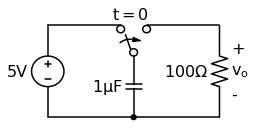

In [3]:
from ipywidgets import interact
import ipywidgets
import matplotlib.pyplot as plt    

@interact(V=ipywidgets.IntSlider(min=0,max=15,step=1,value=5),
          R=ipywidgets.IntSlider(min=100,max=1500,step=100,value=100),
          C=ipywidgets.IntSlider(min=0,max=15,step=1,value=1))
def schem_demo(V, R, C, xkcdmode=False):
    if xkcdmode: plt.xkcd()
    d = schem.Drawing()
    V1 = d.add(e.SOURCE_V, label='{}V'.format(V))
    d.add(e.LINE, d='right', l=d.unit*.75)
    S1 = d.add(e.SWITCH_SPDT2_CLOSE, d='up', anchor='b', rgtlabel='$t=0$')
    d.add(e.LINE, d='right', xy=S1.c,  l=d.unit*.75)
    d.add(e.RES, d='down', label='${}\Omega$'.format(R), botlabel=['+','$v_o$','-'])
    d.add(e.LINE, to=V1.start)
    d.add(e.CAP, xy=S1.a, d='down', toy=V1.start, label='{}$\mu$F'.format(C))
    d.add(e.DOT)
    d.draw(showplot=False)

### `circuitikz`

Draw circuits using `circuitikz`.

In [4]:
%load_ext tikz_magic

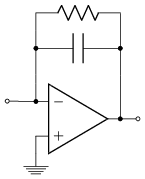

In [5]:
%%tikz -p circuitikz,gnuplottex -s 0.3
%Example circuit from: https://tex.stackexchange.com/a/379915
[every pin/.append style={align=left, text=blue}]
  \draw
  (0, 0) node[op amp] (opamp) {}
  (opamp.-) to[short,-o] (-2, 0.5)
  (opamp.-) to[short,*-] ++(0,1.5) coordinate (leftC)
            to[C]           (leftC -| opamp.out)
            to[short,-*]    (opamp.out)
            to[short,-o] ++ (0.5,0)
  (leftC)   to[short,*-] ++ (0,1)  coordinate (leftR) 
            to[R]           (leftR -| opamp.out)
            to[short,-*]    (leftC -| opamp.out)
   (opamp.+) -- ++ (0,-0.5) node[ground] {};

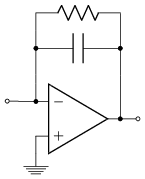

In [6]:
cct=r'''
  \draw
  (0, 0) node[op amp] (opamp) {}
  (opamp.-) to[short,-o] (-2, 0.5)
  (opamp.-) to[short,*-] ++(0,1.5) coordinate (leftC)
            to[C]           (leftC -| opamp.out)
            to[short,-*]    (opamp.out)
            to[short,-o] ++ (0.5,0)
  (leftC)   to[short,*-] ++ (0,1)  coordinate (leftR) 
            to[R]           (leftR -| opamp.out)
            to[short,-*]    (leftC -| opamp.out)
   (opamp.+) -- ++ (0,-0.5) node[ground] {};'''

%tikz -p circuitikz -s 0.3 --var cct

In [7]:
!kpsewhich bodegraph.sty 

/usr/share/texlive/texmf-dist/tex/latex/bodegraph/bodegraph.sty


In [61]:
!kpsewhich circuitikz.sty

/usr/share/texlive/texmf-dist/tex/latex/circuitikz/circuitikz.sty


## Simulating Circuits

As well as drawing circuits, there several different approaches to simulating circuit behaviour.

### Circuit Analysis - `lcapy`

`lcapy` is a linear circuit analysis package.

Whilst the analysis seems buggy at the moment, we can still render circuits.

In [2]:
%%capture
#It seems as if lcapy, as of 7/9/18 doesn't work with current symp 1.2+
!pip install --upgrade sympy==1.1

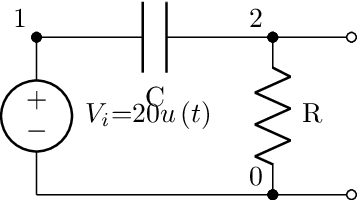

In [2]:
from lcapy import Circuit, j, omega

cct = Circuit()
cct.add("""
Vi 1 0_1 step 20; down
C 1 2; right, size=1.5
R 2 0; down
W 0_1 0; right
W 0 0_2; right, size=0.5
P1 2_2 0_2; down
W 2 2_2;right, size=0.5""")

cct.draw()

In [26]:
H = (cct.R.V('s') / cct.Vi.V('s')).simplify()
H

  C⋅R⋅s  
─────────
C⋅R⋅s + 1

In [27]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [42]:
from ipywidgets import interact

@interact(R=(1,10,1))
def response(R=1):
    cct = Circuit()

    cct.add('V 0_1 0 step 10;down')
    cct.add('L 0_1 0_2 1e-3;right')
    cct.add('C 0_2 1 1e-4;right')
    cct.add('R 1 0_4 {R};down'.format(R=R))
    cct.add('W 0_4 0; left')

    import numpy as np
    t = np.linspace(0, 0.01, 1000)
    vr = cct.R.v.evaluate(t)

    from matplotlib.pyplot import figure, savefig
    fig = figure()
    ax = fig.add_subplot(111, title='Resistor voltage (R={}$\Omega$)'.format(R))
    ax.plot(t, vr, linewidth=2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Resistor voltage (V)')
    ax.grid(True)
    
    cct.draw()

A Jupyter Widget

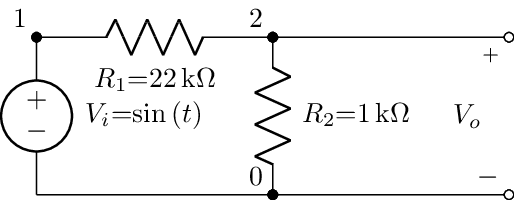

In [3]:
#Example from http://lcapy.elec.canterbury.ac.nz/schematics.html#introduction
sch='''
Vi 1 0_1 {sin(t)}; down
R1 1 2 22e3; right, size=1.5
R2 2 0 1e3; down
P1 2_2 0_2; down, v=V_{o}
W 2 2_2; right, size=1.5
W 0_1 0; right
W 0 0_2; right
'''

fn="voltageDivider.sch"
with open(fn, "w") as text_file:
    text_file.write(sch)
    
cct = Circuit(fn)
cct.draw(style='american') #american, british, european
#I wonder if we could blend the styles to make an OU style?

In [5]:
%matplotlib inline

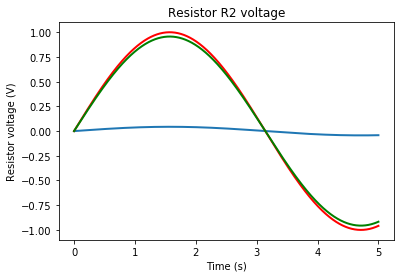

In [11]:
#How do I analyse the circuit with the ac voltage source?

import numpy as np
t = np.linspace(0, 5, 1000)
vr = cct.R2.v.evaluate(t)
from matplotlib.pyplot import figure, savefig
fig = figure()
ax = fig.add_subplot(111, title='Resistor R2 voltage')
ax.plot(t, vr, linewidth=2)
ax.plot(t, cct.Vi.v.evaluate(t), linewidth=2, color='red')
ax.plot(t, cct.R1.v.evaluate(t), linewidth=2, color='green')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Resistor voltage (V)');

In [36]:
?cct.R2.v

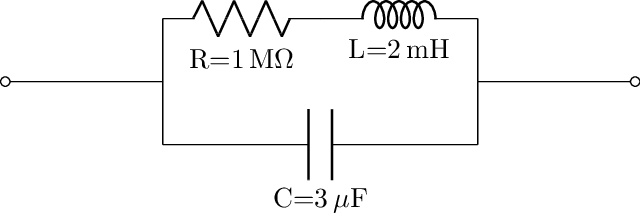

In [58]:
from lcapy import Circuit

cct = Circuit()
cct.add("""
W _0 _1; right
W _1 _2; up,size=0.4
R _2 _3 1e6; right
L _3 _4 2e-3;right
W _4 _5; down,size=0.4
W _5 _6; right
W _5 _7; down,size=0.4
C _7 _8 3e-6; left
W _8 _1; up,size=0.4
""")

cct.draw(style='british')

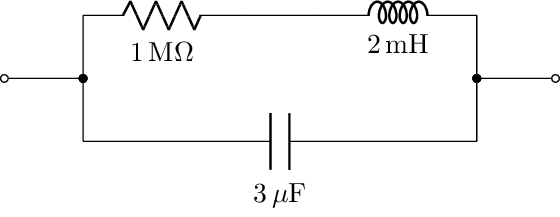

In [61]:
#alternative way of drawing circuits
from lcapy import R, C, L

cct2= (R(1e6) + L(2e-3)) | C(3e-6)
#For some reason, the style= argument is not respected
cct2.draw()

## *Circuit Sandbox*

The [Circuit Sandbox](https://github.com/willymcallister/circuit-sandbox) is a simple, standalone Javascript circuit simulator that we can embed in a notebook or [run in its own browser tab](js/circuit-sandbox-master/index.html).

The *Circuit Sandbox* can save and load simple netlists (*I don't know if these can then be used by other packages?*)

In [63]:
from IPython.display import IFrame
IFrame('js/circuit-sandbox-master/index-mobile.html', width=1000,height=600)

## Digital Circuit Simulator

`simcirjs` [[docs](https://github.com/kazuhikoarase/simcirjs)) is a syandalone Javascript digital circuit simulator that we can embed in a notebook or [run in its own browser tab](js/simcirjs-master/sample.html).

In [64]:
#!ls js/simcirjs-master/
from IPython.display import IFrame
IFrame('js/simcirjs-master/blank.html', width=600,height=300)

### `ahkab`

[`ahkab`](https://ahkab.readthedocs.io/en/latest/index.html) is an open-source SPICE-like interactive circuit simulator.

*Unfortunately, it doesn't render the schematic diagram from the circuit description. It would be useful if we `ahkab` could work with something like `schemdraw` to support such a dual behaviour from the same circuit descrpition.*

The examples below are based on the original documentation.

In [65]:
import ahkab

In [66]:
cct = ahkab.Circuit('Simple Example Circuit')

cct.add_resistor('R1', 'n1', cct.gnd, value=5)
cct.add_vsource('V1', 'n2', 'n1', dc_value=8)
cct.add_resistor('R2', 'n2', cct.gnd, value=2)
cct.add_vsource('V2', 'n3', 'n2', dc_value=4)
cct.add_resistor('R3', 'n3', cct.gnd, value=4)
cct.add_resistor('R4', 'n3', 'n4', value=1)
cct.add_vsource('V3', 'n4', cct.gnd, dc_value=10)
cct.add_resistor('R5', 'n2', 'n4', value=4)

opa = ahkab.new_op()
r = ahkab.run(cct, opa)['op']
print(r)

OP simulation results for 'Simple Example Circuit'.
Run on 2017-12-08 22:28:25, data file /tmp/tmp_k1yz97v.op.
Variable    Units        Value         Error    %
----------  -------  ---------  ------------  ---
VN1         V        -3.86364    3.86358e-12    0
VN2         V         4.13636   -4.13591e-12    0
VN3         V         8.13636   -8.13602e-12    0
VN4         V        10         -1.00027e-11    0
I(V1)       A        -0.772727   0              0
I(V2)       A        -0.170455   0              0
I(V3)       A        -3.32955    0              0


## Boolean Algebra - `PyEDA`

`PyEDA` is a [Python package for exploring Boolean algebra](http://pyeda.readthedocs.io/en/latest/boolalg.html).

In [67]:
from pyeda.inter import *

A = exprvar('A')
B = exprvar('B')
C = exprvar('C')

In [68]:
A & B

And(A, B)

In [69]:
A & ~B

And(A, ~B)

In [70]:
(A | B) & C

And(Or(A, B), C)

In [71]:
A ^ B

Xor(A, B)

In [72]:
expr2truthtable(A & ~B)

B A
0 0 : 0
0 1 : 1
1 0 : 0
1 1 : 0

In [73]:
expr2truthtable( Or(And(A, B), And(A, C)) )

C B A
0 0 0 : 0
0 0 1 : 0
0 1 0 : 0
0 1 1 : 1
1 0 0 : 0
1 0 1 : 1
1 1 0 : 0
1 1 1 : 1

In [74]:
expr2truthtable( And('X', 'Y') )

Y X
0 0 : 0
0 1 : 0
1 0 : 0
1 1 : 1

In [75]:
tt = truthtable(reversed([A,B,C]), "00010111")
tt

A B C
0 0 0 : 0
0 0 1 : 0
0 1 0 : 0
0 1 1 : 1
1 0 0 : 0
1 0 1 : 1
1 1 0 : 1
1 1 1 : 1

In [76]:
truthtable2expr( tt ) 

Or(And(~A, B, C), And(A, ~B, C), And(A, B, ~C), And(A, B, C))